Washington
Illinois
California
Arizona
Massachusetts
Wisconsin
Texas
Nebraska
Utah
Oregon
Florida
New York
Rhode Island
Georgia
New Hampshire
North Carolina
New Jersey
Colorado
Maryland
Nevada
Tennessee
Hawaii
Indiana
Kentucky
Minnesota
Oklahoma
Pennsylvania
South Carolina
District of Columbia
Kansas
Missouri
Vermont
Virginia
Connecticut
Iowa
Louisiana
Ohio
Michigan
South Dakota
Arkansas
Delaware
Mississippi
New Mexico
North Dakota
Wyoming
Alaska
Maine
Alabama
Idaho
Montana
Puerto Rico
West Virginia


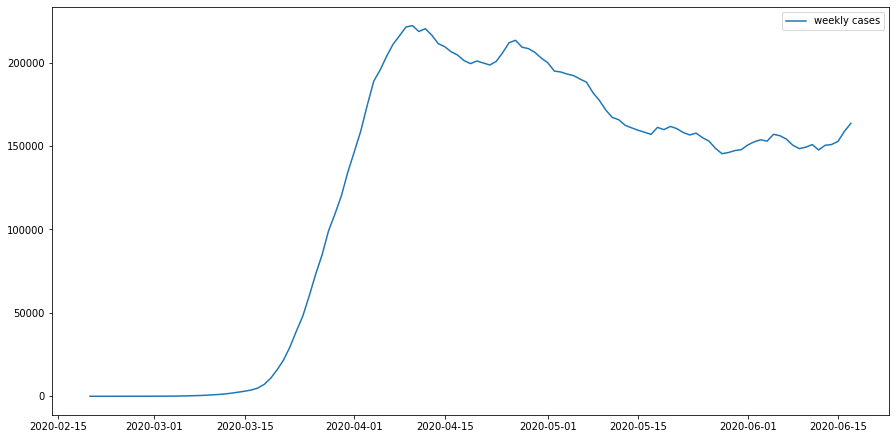

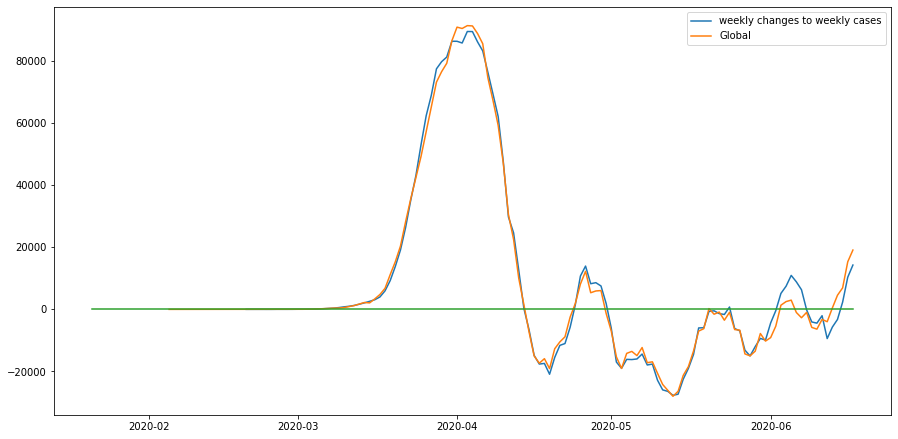

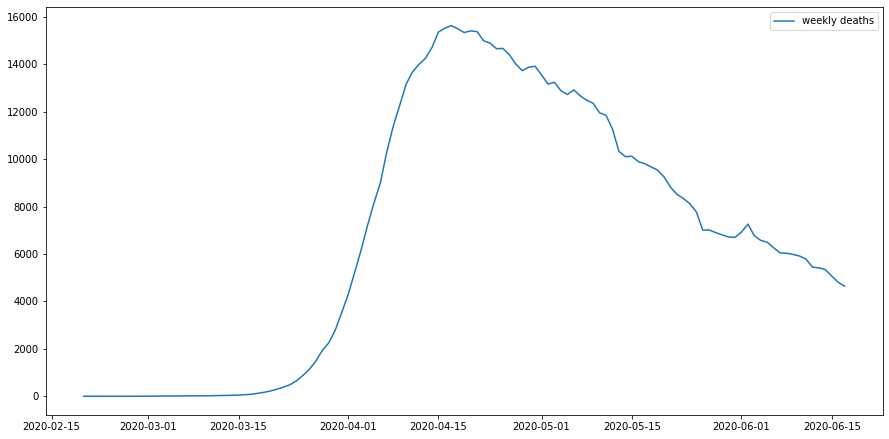

In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os

#######################################################################################################################
#######################################################################################################################
############################################ Download Data ############################################################
#######################################################################################################################
#######################################################################################################################
raw_US = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv', 
                     index_col = 'date',
                     parse_dates = True).sort_index()
raw_states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv',
                     index_col = 'date',
                     parse_dates = True).sort_index()
raw_County = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv',
                     index_col = 'date',
                     parse_dates = True).sort_index()

raw_Global = pd.read_csv("https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv",
                        ).groupby('Country/Region').sum().transpose()[2:]
raw_Global.index = pd.to_datetime(raw_Global.index)

cty_population = pd.read_csv('county population.csv', encoding='cp1252')
cty_population.columns = ['state', 'county', 'population']
cty_population = cty_population.loc[cty_population.state != cty_population.county]
cty_population.county = cty_population.apply(lambda row: row.county.replace(" County", "" ), axis = 1)
cty_population = cty_population.set_index(['state','county'])

population = pd.read_html('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population')[0].set_index(['State'])["Population estimate, July 1, 2019[2]"]
pop_dict = dict(population)
pop_dict['Virgin Islands'] = pop_dict['U.S. Virgin Islands']
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################

raw_states['cases per million'] = raw_states.apply(lambda row: 1000000*row.cases/pop_dict[row.state], axis = 1)
raw_states['deaths per million'] = raw_states.apply(lambda row: 1000000*row.deaths/pop_dict[row.state], axis = 1)

#print(raw_US.head())
#print(raw_states.head(), '\n')

list_of_states = raw_states['state'].unique()
new_weekly_cases_state = {}
percent_weekly_cases = {}
change_in_new_cases = {}
new_cases_per_mil = {}
new_death_per_mil = {}

temp_county = []
temp_dict = {}
wk_cases_county = {}
wk_deaths_county = {}
cases_cty_thou = {}

for state in list_of_states:
    total_case = round(100*raw_states.loc[raw_states['state'] == state].cases[-1]/raw_US.cases[-1], 4)
    if ( pop_dict[state] > 500000):
        wk_cases_county[state] = {}
        wk_deaths_county[state] = {}
        cases_cty_thou[state] = {}
        temp_county = raw_County.loc[raw_County.state == state]
        #print(temp_county.county.unique())
        print(state)
        for cnty in temp_county.county.unique():
            if cnty == 'Unknown':
                continue
            wk_cases_county[state][cnty] = temp_county.loc[temp_county.county == cnty ].cases.diff(7)
            wk_deaths_county[state][cnty] = temp_county.loc[temp_county.county == cnty ].deaths.diff(7)
            #cases_cty_thou[state][cnty] = 1000*wk_cases_county[state][cnty]/cty_population.loc[state, cnty]
            #Replace 'cnty' with something common across platforms, like 'fip'

        new_weekly_cases_state[state] = raw_states.loc[raw_states['state'] == state].cases.diff(7)/7
        new_cases_per_mil[state] = raw_states.loc[raw_states['state'] == state]['cases per million'].diff(7)/7
        new_death_per_mil[state] = raw_states.loc[raw_states['state'] == state]['deaths per million'].diff(7)/7
        percent_weekly_cases[state] = 100*raw_states.loc[raw_states['state'] == state].cases.diff(7)/raw_US.cases.diff(7)
        change_in_new_cases[state] = 100*new_cases_per_mil[state].diff(14)[-1]/new_cases_per_mil[state][-15]
        cases_county[state] = {}
        deaths_county[state] = {}

temp = raw_US.cases.diff(7).diff(7)
for t in raw_US.cases.diff(7).diff(7).index:
    temp[t] = 0

plt.figure(figsize = (15,7.5))
plt.plot(raw_US.cases.diff(7)[30:], label = "weekly cases" )
#plt.plot(raw_Global['US'].diff(7), label = "Global" )
#plt.plot(raw_Global['India'].diff(7), label = 'India')
plt.legend()


plt.figure(figsize = (15,7.5))
plt.plot(raw_US.cases.diff(7).diff(7)[30:], label = "weekly changes to weekly cases" )
plt.plot(raw_Global['US'].diff(7).diff(7), label = "Global" )
plt.plot(temp)
plt.legend()

plt.figure(figsize = (15,7.5))
plt.plot(raw_US.deaths.diff(7)[30:], label = "weekly deaths")
plt.legend()

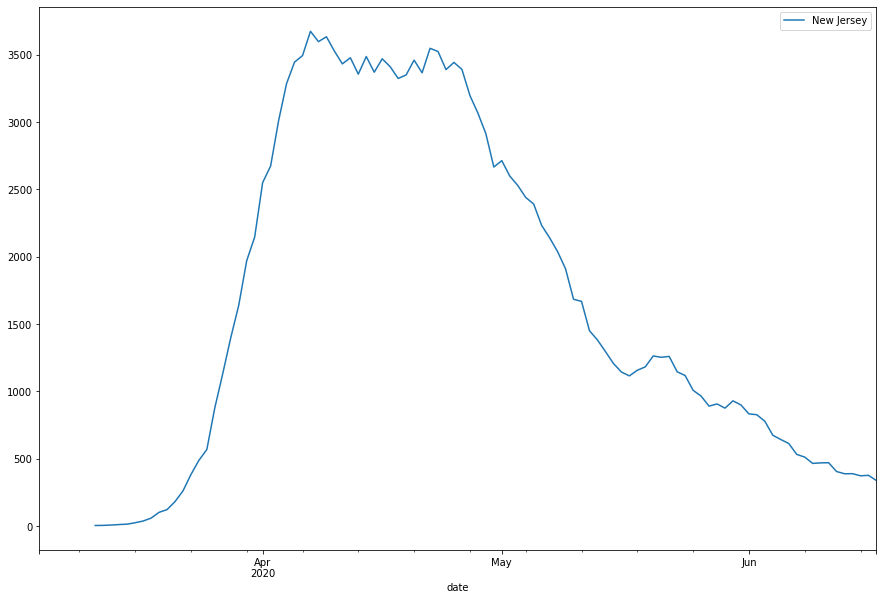

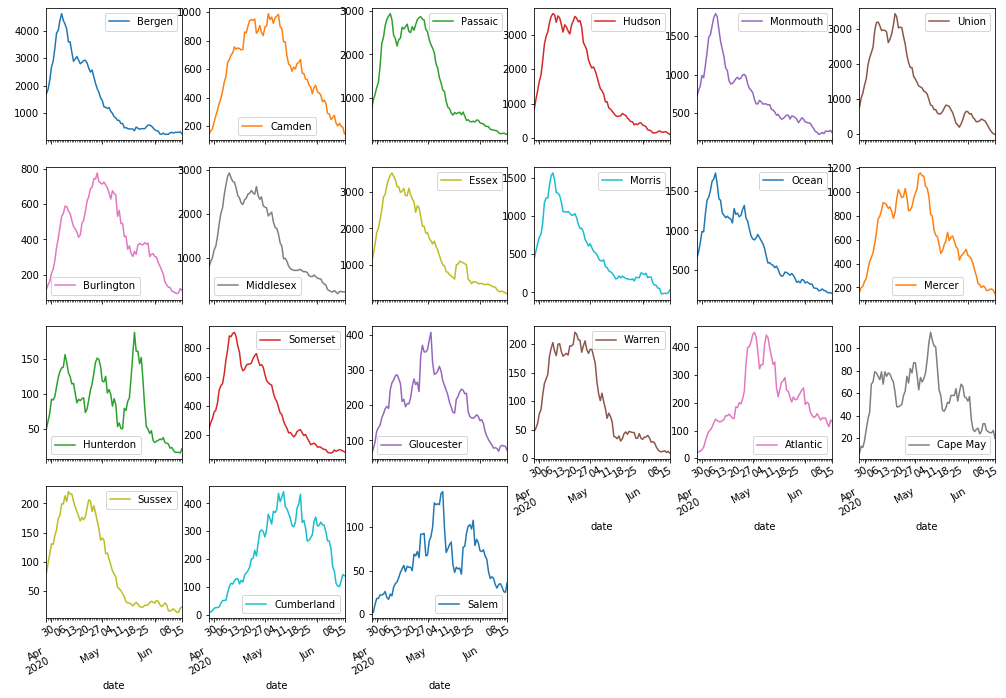

In [90]:
oregon = wk_cases_county['New Jersey']
ore = pd.DataFrame()
new_weekly_cases_state['New Jersey'].plot(label = 'New Jersey', figsize = (15,10))
plt.legend()
for ct in oregon:
    if oregon[ct].sum() > 1000:
        ore[ct] = oregon[ct]
#print(ore.head())
ore.dropna(inplace = True)
ore.plot(subplots = True, layout = (10, 6), figsize = (17,32))
plt.show()

#for cty, cs in wk_cases_county['Oregon'].items():
#    cs.dropna(inplace = True)
#    pop = cty_population.loc['Oregon', cty].population
#    print(pop)
#    if cty == 'Lane':
#        plt.plot(cs, label = cty, marker = 'x')
#    else:
#        plt.plot(cs, label = cty)


['Arizona', 'Texas', 'Utah', 'Oregon', 'Florida', 'Georgia', 'North Carolina', 'Nevada', 'Hawaii', 'Oklahoma', 'South Carolina', 'Vermont', 'Louisiana', 'Arkansas', 'Wyoming', 'Alaska', 'Alabama', 'Idaho', 'Montana', 'Puerto Rico']
['Illinois', 'Massachusetts', 'Wisconsin', 'Nebraska', 'New York', 'Rhode Island', 'New Hampshire', 'New Jersey', 'Colorado', 'Maryland', 'Minnesota', 'Pennsylvania', 'District of Columbia', 'Virginia', 'Connecticut', 'Ohio', 'Michigan', 'Delaware', 'Maine', 'West Virginia']


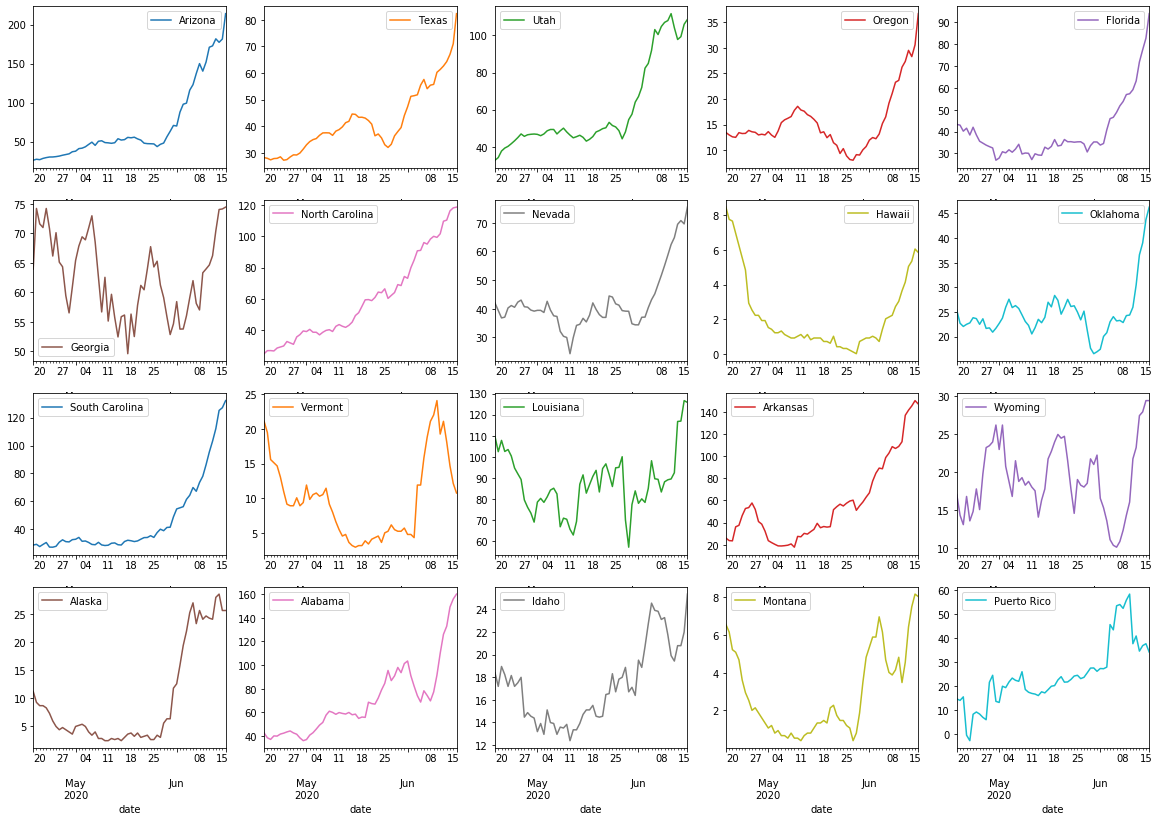

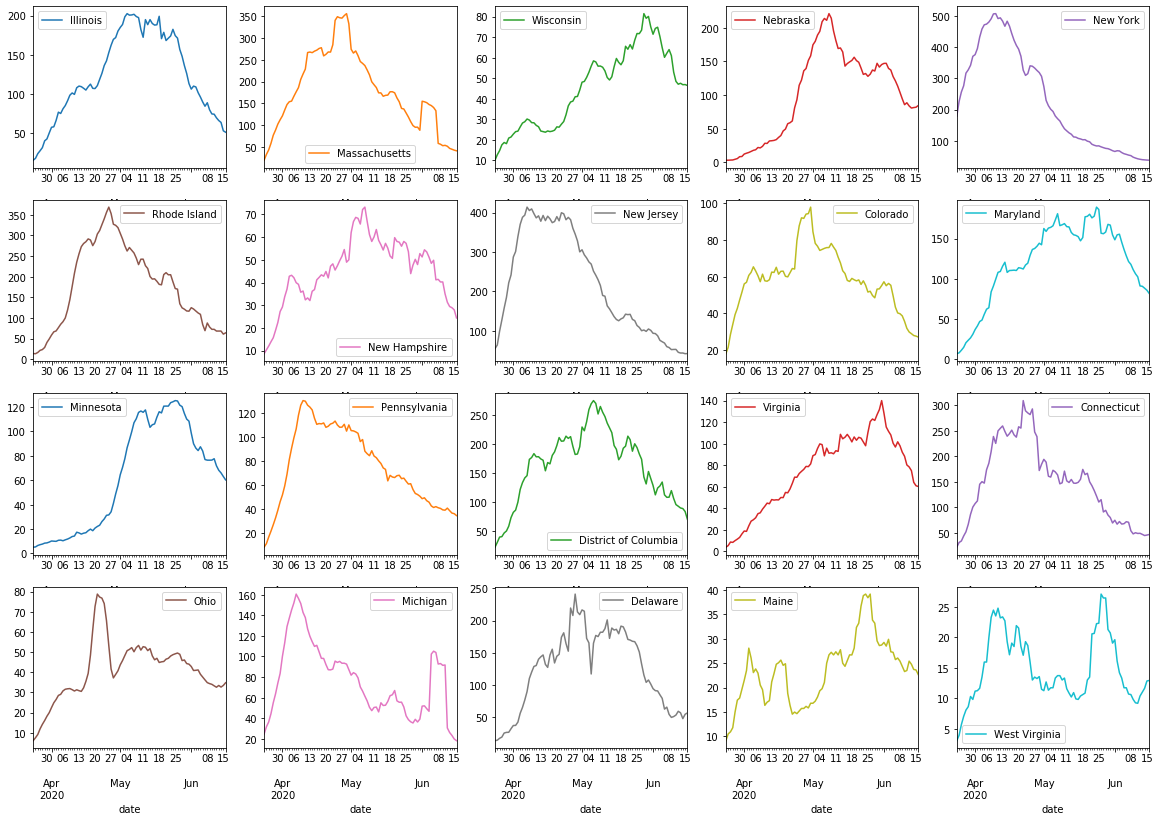

In [17]:
order = list(change_in_new_cases.values())
order.sort(reverse = True)
top_10_states = [key for key, value in change_in_new_cases.items() if value in order[:10] ]
bottom_states = [key for key, value in change_in_new_cases.items() if value in order[-10:]]
print(top_10_states)
print(bottom_states)

top_10 = pd.DataFrame()
bottom = pd.DataFrame()
for st in top_10_states:
    top_10[st] = new_cases_per_mil[st][-60:]
#    top_10[st] = new_weekly_cases_state[st]
for st in bottom_states:
    bottom[st] = new_cases_per_mil[st]
    
top_10.dropna(inplace = True)
top_10.plot(subplots = True, layout = (10,5), figsize = (20,35), sharex=False)

bottom.dropna(inplace = True)
bottom.plot(subplots = True, layout = (10,5), figsize = (20,35), sharex=False)
plt.show()
#top_10['Oregon'].plot(figsize = (10,7.5))

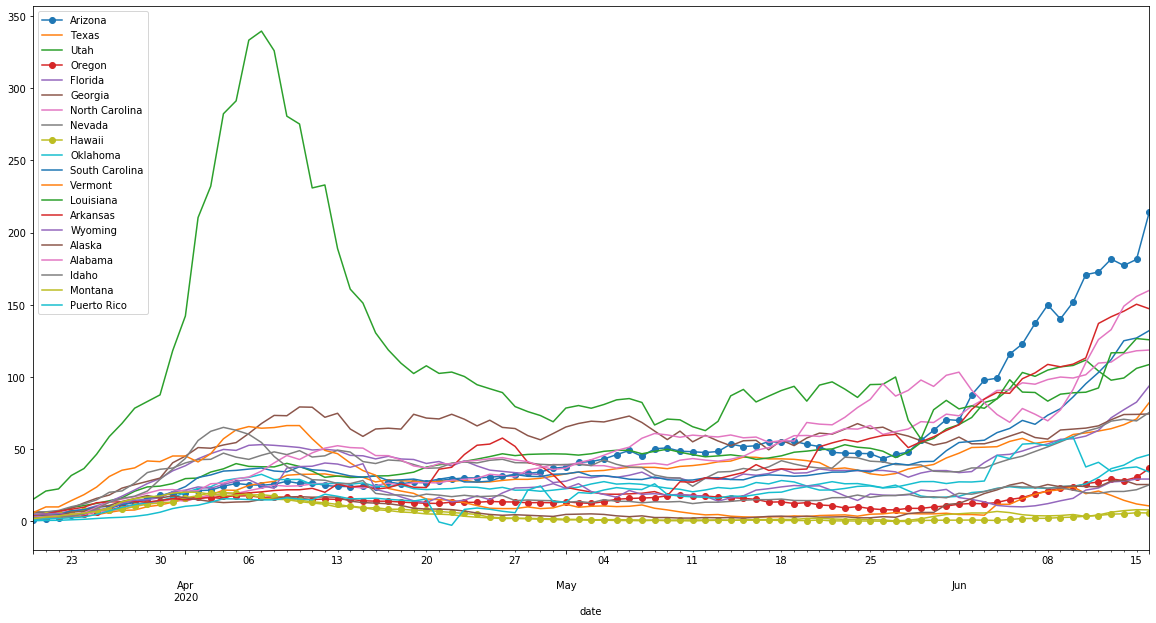

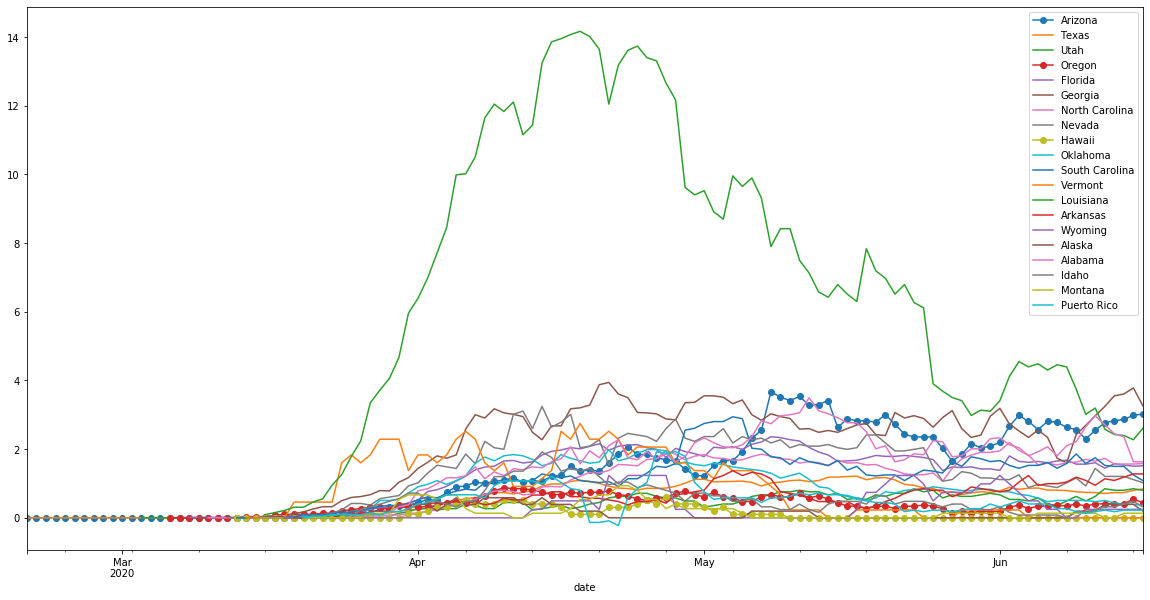

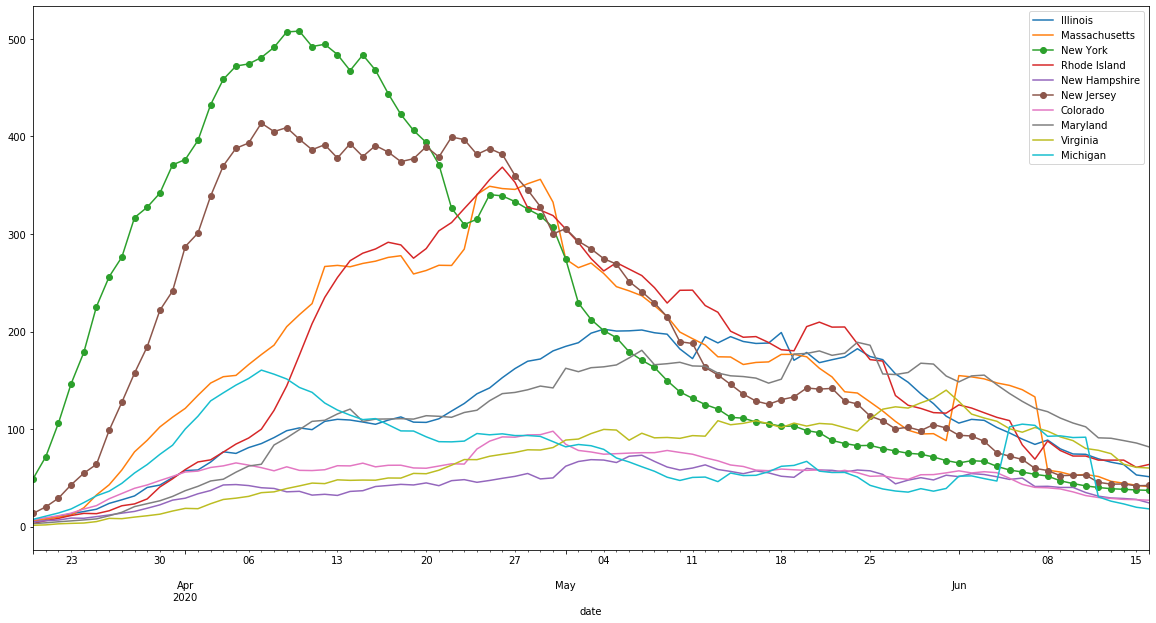

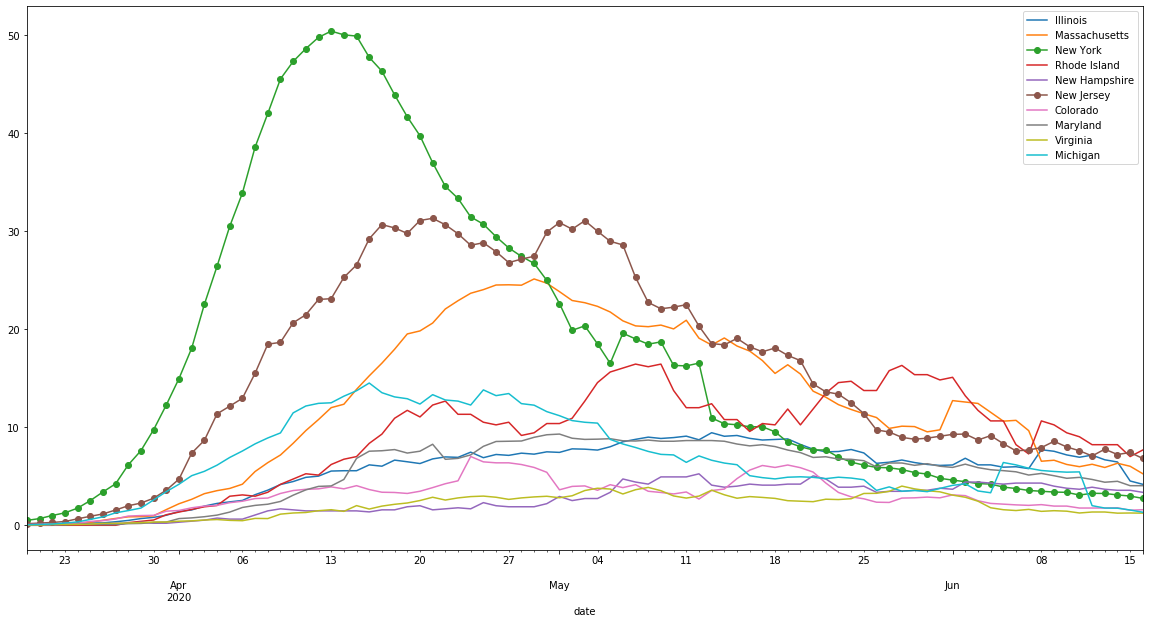

In [13]:


plt.figure(figsize = (20,10))
for st in top_10_states:
    if st == 'Hawaii' or st == 'Arizona' or st == 'Oregon' :
        new_cases_per_mil[st]['2020-03-20':].plot(label = st, marker='o')
    else :
        new_cases_per_mil[st]['2020-03-20':].plot(label = st )
plt.legend()

plt.figure(figsize = (20,10))
for st in top_10_states:
    if st == 'Hawaii' or st == 'Arizona' or st == 'Oregon':
        new_death_per_mil[st]['2020-02-20':].plot(label = st, marker='o')
    else :
        new_death_per_mil[st]['2020-02-20':].plot(label = st )
plt.legend()


plt.figure(figsize = (20,10))
for st in bottom_states:
    if st == 'New Jersey' or st == 'New York' :
        new_cases_per_mil[st]['2020-03-20':].plot(label = st, marker='o')
    else :
        new_cases_per_mil[st]['2020-03-20':].plot(label = st )
plt.legend()

plt.figure(figsize = (20,10))
for st in bottom_states:
    if st == 'New Jersey' or st == 'New York' :
        new_death_per_mil[st]['2020-03-20':].plot(label = st, marker='o')
    else :
        new_death_per_mil[st]['2020-03-20':].plot(label = st )

plt.legend()

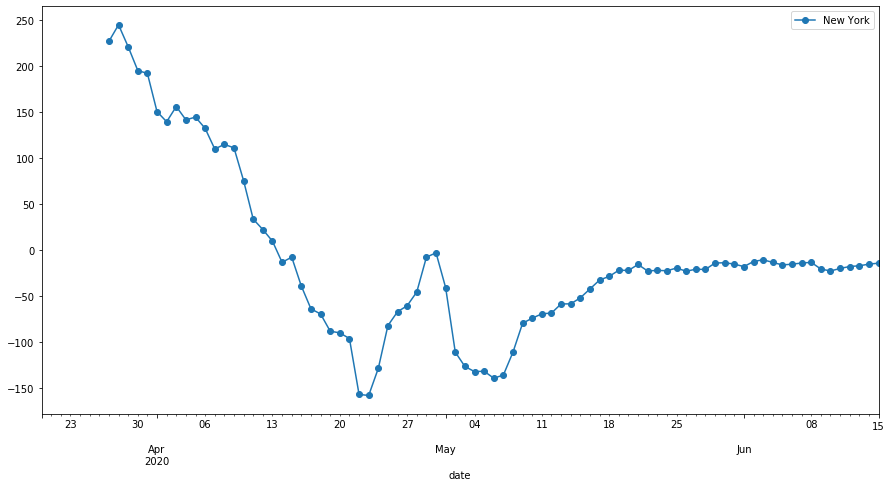

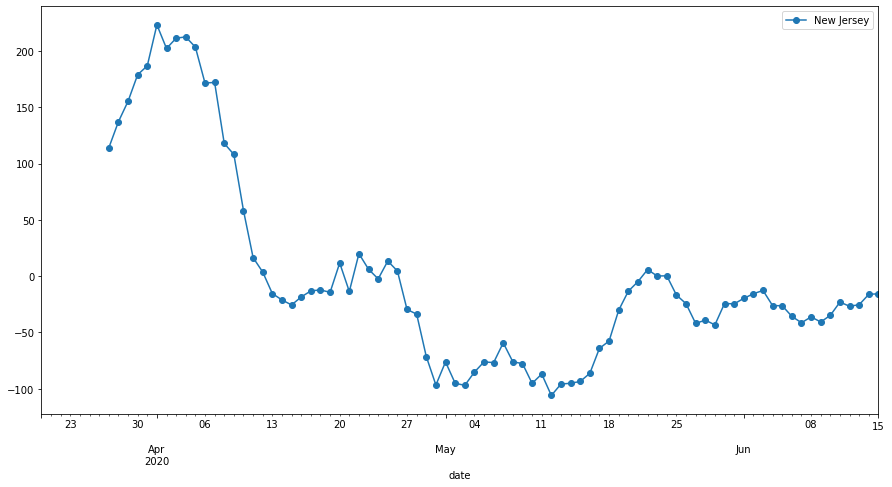

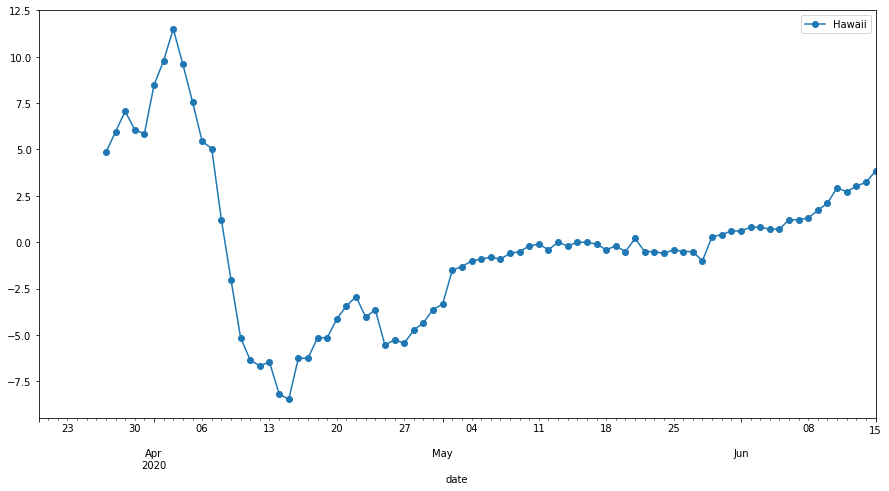

In [45]:
interested_state = ['New York', 'New Jersey', 'Hawaii']

for st in interested_state:
    plt.figure(figsize = (15,7.5))
    new_cases_per_mil[st]['2020-03-20':].diff(7).plot(label = st, marker='o')
    plt.legend()



In [38]:
def start_of_pandemic(cases, ratio = -1, limit = -1):
    if limit == -1:
        return [ date for date, val in dict(cases).items() if val >= cases.max()/ratio ][0].date() + dt.timedelta(days = -1)
    else:
        return [ date for date, val in dict(cases).items() if val >= limit ][0].date() + dt.timedelta(days = -1)

for st, cases in new_cases_per_mil.items():
    cases.dropna(inplace = True)
    print(st, "\t", start_of_pandemic(cases, ratio = 3), 
          "\t", [ date for date, val in dict(cases).items() if val < cases.max()/3 ][-1].date() )

Washington 	 2020-03-22 	 2020-03-22
Illinois 	 2020-04-03 	 2020-06-15
California 	 2020-04-01 	 2020-04-01
Arizona 	 2020-05-29 	 2020-05-29
Massachusetts 	 2020-03-31 	 2020-06-15
Wisconsin 	 2020-04-04 	 2020-04-21
Texas 	 2020-04-05 	 2020-04-05
Nebraska 	 2020-04-22 	 2020-04-22
Utah 	 2020-04-04 	 2020-04-19
Oregon 	 2020-03-27 	 2020-05-30
Florida 	 2020-03-29 	 2020-05-11
New York 	 2020-03-23 	 2020-06-15
Rhode Island 	 2020-04-08 	 2020-06-15
Georgia 	 2020-03-28 	 2020-03-28
New Hampshire 	 2020-03-30 	 2020-03-30
North Carolina 	 2020-04-29 	 2020-05-09
New Jersey 	 2020-03-27 	 2020-06-15
Colorado 	 2020-03-26 	 2020-06-15
Maryland 	 2020-04-06 	 2020-04-06
Nevada 	 2020-03-27 	 2020-03-27
Tennessee 	 2020-03-30 	 2020-03-30
Hawaii 	 2020-03-22 	 2020-06-15
Indiana 	 2020-03-30 	 2020-03-30
Kentucky 	 2020-04-04 	 2020-04-04
Minnesota 	 2020-04-28 	 2020-04-28
Oklahoma 	 2020-03-30 	 2020-03-30
Pennsylvania 	 2020-03-30 	 2020-06-15
South Carolina 	 2020-05-30 	 2020-05-3

In [ ]:
help(cases)

In [ ]:
###t = raw_US.index.to_list()[30:]
#data1 = raw_US.cases.diff(7).diff()[30:]
#data2 = raw_US.deaths.diff(7).diff()[30:]

###data1 = raw_US.cases.diff(7)[30:]
###data2 = raw_US.deaths.diff(7)[30:]


###fig, ax1 = plt.subplots( figsize=(20,15) )

###color = 'tab:red'
###ax1.set_xlabel('date')
###ax1.set_ylabel('Cases', color=color)
#ax1.set_ylabel('Cases')
###ax1.plot(t, data1, color=color)
#ax1.plot(t, data1)
#ax1.tick_params(axis='y', labelcolor=color)
###ax1.tick_params(axis='y')
###ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
#ax2.set_ylabel('Deaths', color=color)  # we already handled the x-label with ax1
###ax2.set_ylabel('Deaths')  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
###ax2.plot(t, data2)
#ax2.tick_params(axis='y', labelcolor=color)
###ax2.tick_params(axis='y')

###fig.tight_layout()  # otherwise the right y-label is slightly clipped
###plt.show()